# Seat availability at La Permanence: modeling and forecasting

[La Permanence](https://www.la-permanence.com) is a coworking space with two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).
Our purpose is to model and then predict the number the available seats.

## Imports

In [1]:
import datetime
import os
import pandas as pd
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

days_of_the_week = {0: 'Mo', 1: 'Tu', 2: 'We', 3: 'Th', 4: 'Fr', 5: 'Sa', 6: 'Su'}

RULE = "10T" # resampling rule: resolution of time regularization

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.

In [3]:
%%time
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',')
print("Shape of dataframe: {0}.".format(raw_data.shape))

Size of data file: 419KB.
Loading data...
Shape of dataframe: (16191, 3).
CPU times: user 12.4 ms, sys: 3.16 ms, total: 15.5 ms
Wall time: 14.3 ms


## Preprocessing

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16191 entries, 0 to 16190
Data columns (total 3 columns):
timestamp    16191 non-null object
Moulin       16191 non-null int64
Alésia       16191 non-null int64
dtypes: int64(2), object(1)
memory usage: 379.6+ KB


Data info:
- `timestamp` gives the date and time (UTC) of data collection in the format `YYYY-MM-DD-hh-mm-ss` where 
  - `YYYY=`year,
  - `MM=`month,
  - `DD=`day,
  - `hh=`hour,
  - `mm=`minute,
  - `ss`=second;
- `Moulin` gives the number of available seats at the *rue du Fer à Moulin* location;
- `Alésia` gives the number of available seats at the *rue d'Alésia* location.

Save data as a separate dataframe and adjust for timezone:

In [5]:
attendance = raw_data.copy()

attendance['timestamp'] = attendance['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
attendance['timestamp'] = attendance['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))
attendance.set_index("timestamp", inplace=True)

## Time regularization

The data was collected at irregular times, as can be seen by zooming in on a short window frame.

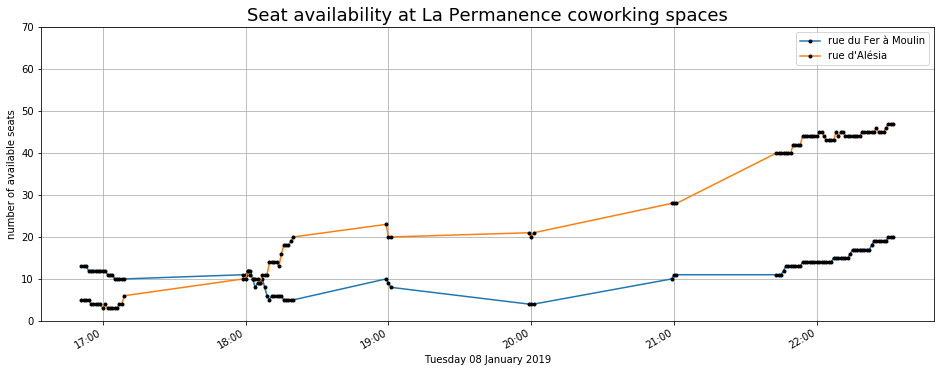

In [6]:
idx_range = range(100, 200)
the_day = attendance.index[idx_range[0]]
the_hours = list(set([x.hour for x in attendance.index[idx_range]]))

hour_range = pd.date_range(pd.Timestamp(the_day.year, the_day.month, the_day.day, the_day.hour), periods=the_hours[-1] - the_hours[0], freq= 'H')

fig, ax = plt.subplots(figsize=(16, 6));
attendance.iloc[idx_range].plot(ax=ax, style='-o', **{"markersize": 3, "markerfacecolor": "k", "markeredgecolor": "k"});

ax.set_title("Seat availability at La Permanence coworking spaces", fontsize=18)

ax.set_ylabel("number of available seats")
ax.set_yticks(range(0, 80, 10))

ax.set_xlabel(the_day.strftime('%A %d %B %Y'))
ax.set_xticks(hour_range)
ax.set_xticklabels([x.strftime("%H:00") for x in hour_range])

ax.legend(["rue du Fer à Moulin", "rue d'Alésia"])
ax.grid()

Resample (at a resolution of 10 minutes) and interpolate to regularize the data.

In [7]:
attendance = attendance.resample(RULE).mean().interpolate()

We obtain a regularized time-series:

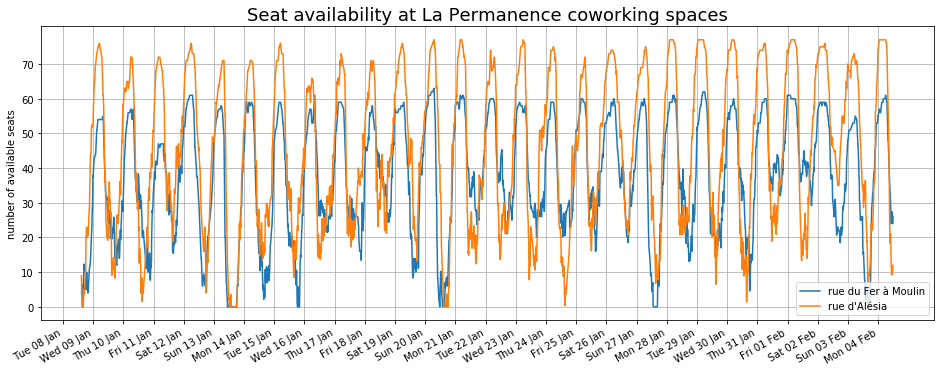

In [8]:
fig, ax = plt.subplots(figsize=(16, 6));
attendance[['Moulin', 'Alésia']].plot(ax=ax);

ax.set_title("Seat availability at La Permanence coworking spaces", fontsize=18)

ax.set_ylabel("number of available seats");
ax.set_yticks(range(0, 80, 10))

ax.axes.get_xaxis().label.set_visible(False);
ts_min = attendance.index.min()
ts_max = attendance.index.max()
attendance_date_range = pd.date_range(ts_min.date(), ts_max.date());
ax.set_xticks(attendance_date_range)
ax.set_xticklabels([pd.to_datetime(pandas_datetime).strftime("%a %d %b") for pandas_datetime in attendance_date_range]);

ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);
ax.grid()

# Averaging

Our next goal is to have a representative for each day of the week and for the two locations separately.

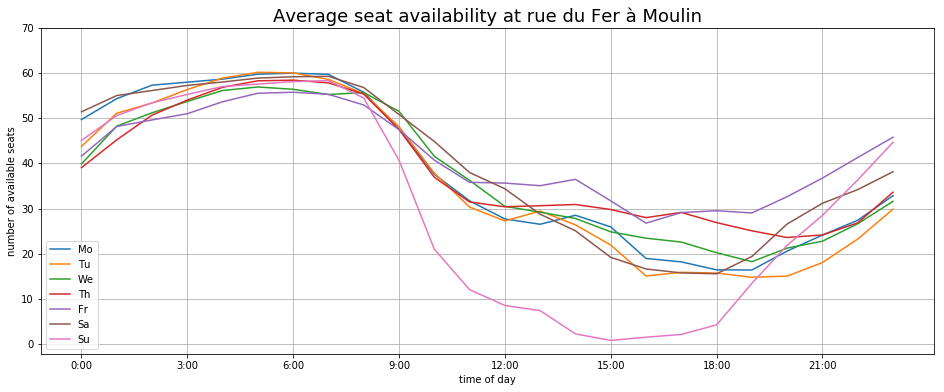

In [9]:
moulin = attendance.loc[:, ['Moulin']]
moulin_by_day_of_week = pd.pivot_table(moulin, index=moulin.index.hour, columns=moulin.index.dayofweek, values='Moulin', aggfunc='mean')

fig, ax = plt.subplots(figsize=(16, 6));
moulin_by_day_of_week.plot(ax=ax);

ax.set_title("Average seat availability at rue du Fer à Moulin", fontsize=18)
ax.set_ylabel("number of available seats")
ax.set_xlabel("time of day")

ax.set_yticks(range(0, 80, 10))
ax.set_xticks(range(0,24, 3))
ax.set_xticklabels([f'{int(x)}:00' for x in ax.get_xticks()])

ax.legend(days_of_the_week.values())
ax.grid()


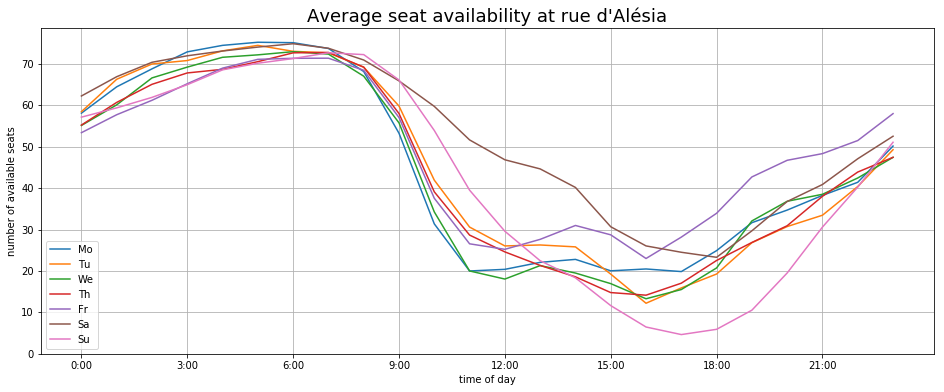

In [10]:
alesia = attendance.loc[:, ['Alésia']]
alesia_by_day_of_week = pd.pivot_table(alesia, index=alesia.index.hour, columns=alesia.index.dayofweek, values='Alésia', aggfunc='mean')

fig, ax = plt.subplots(figsize=(16, 6));
alesia_by_day_of_week.plot(ax=ax);

ax.set_title("Average seat availability at rue d'Alésia", fontsize=18)
ax.set_ylabel("number of available seats")
ax.set_xlabel("time of day")

ax.set_yticks(range(0, 80, 10))
ax.set_xticks(range(0,24, 3))
ax.set_xticklabels([f'{int(x)}:00' for x in ax.get_xticks()])

ax.legend(days_of_the_week.values())
ax.grid()

